## Import Pythonic Libraries
This notebook should be run at [swan.cern.ch](swan.cern.ch).  The notebook parameters used are:
- Python 3
- Software stack: 97
- Platform: CentOS 7 (gcc9)
- Number of cores: 2 or 4
- Memory: 8 or 10 GB

Requires downloading `root` samples (within a directory) to the working directory hosting this notebook.

In [1]:
import os, sys
import time
import numpy as np
from scipy import stats
from sklearn.metrics import auc
import ROOT
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ROOT import TMVA, TFile, TTree, TCut, TRandom3
from ROOT import TCanvas, TGraph
from ROOT import gSystem, gApplication, gROOT

ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.20/02


## Select the samples and variables to compare

In [2]:
# get list of directories in working directory
dirList = next(os.walk(os.getcwd()))[1]

# save path
defaultSaveDir = "Variable Distributions "

# root paths
treeName = "ljmet"

In [3]:
print("Choose the first sample directory for comparison:")
sampleDirOne = widgets.Dropdown( options = dirList )
sampleDirOne

Choose the first sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.InputVariables.ipynb', '.sys.v#.compareROOT.ipynb', 'BRUX', 'FWLJMET102X_1l…

In [4]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirOne.value ))
sampleOne = widgets.SelectMultiple( options = os.listdir( sampleDirOne.value ) )
sampleOne

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2017_Oct2019_4t_05072020_step2:


SelectMultiple(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweight…

In [5]:
print("Choose the second sample directory for comparison:")
sampleDirTwo = widgets.Dropdown( options = dirList )
sampleDirTwo

Choose the second sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.InputVariables.ipynb', '.sys.v#.compareROOT.ipynb', 'BRUX', 'FWLJMET102X_1l…

In [6]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirTwo.value ))
sampleTwo = widgets.SelectMultiple( options = os.listdir( sampleDirTwo.value ) )
sampleTwo

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2018_Oct2019_4t_05072020_step2:


SelectMultiple(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythi…

In [7]:
rootFileOne = {}
rootTreeOne = {}
branchListOne = {}
rootFileTwo = {}
rootTreeTwo = {}
branchListTwo = {}

commonBranches = []

for file in sampleOne.value:
    rootFileOne[file] = ROOT.TFile.Open( sampleDirOne.value + "/" + file )
    rootTreeOne[file] = rootFileOne[file].Get( treeName )
    branchListOne[file] = [ branch.GetName() for branch in rootTreeOne[file].GetListOfBranches() ]

for file in sampleTwo.value:
    rootFileTwo[file] = ROOT.TFile.Open( sampleDirTwo.value + "/" + file )
    rootTreeTwo[file] = rootFileTwo[file].Get( treeName )
    branchListTwo[file] = [ branch.GetName() for branch in rootTreeTwo[file].GetListOfBranches() ]

for fileOne in branchListOne:
    for itr, fileTwo in enumerate(branchListTwo):
        commonBranch = set(branchListOne[fileOne]).intersection(branchListTwo[fileTwo])
        if itr == 0:
            commonBranches = commonBranch
        else:
            commonBranches = commonBranches.intersection(commonBranch)
        
    
print("{} variables shared.".format(
    len(commonBranches)
))

401 variables shared.


### Combine the root files

In [8]:
# get relevant cuts from each root file
cutOne = {}
cutTwo = {}

startTime = time.time()

for file in sampleOne.value:
    cutOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading first sample(s) in {:.2f} seconds".format(time.time()-startTime))

for file in sampleTwo.value:
    cutTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading second sample(s) in {:.2f} seconds".format(time.time()-startTime))

/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)


Finished loading first sample(s) in 3.07 seconds
Finished loading second sample(s) in 5.60 seconds


In [9]:
cutOneComb = np.concatenate([cutOne[file] for file in sampleOne.value])
cutTwoComb = np.concatenate([cutTwo[file] for file in sampleTwo.value])

cutOneSort = np.asarray(cutOneComb[cutOneComb[:,0].argsort()])
cutTwoSort = np.asarray(cutTwoComb[cutTwoComb[:,0].argsort()])

In [10]:
cutOneSort = cutOneComb[np.lexsort((cutOneComb[:,3],cutOneComb[:,0]))]
cutTwoSort = cutTwoComb[np.lexsort((cutTwoComb[:,3],cutTwoComb[:,0]))]

##### Apply selection to the events and evaluate weights

In [11]:
# apply cuts
leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets= 2
nJets = 6

cutMaskOne = np.zeros(np.shape(cutOneSort)[0])
cutMaskTwo = np.zeros(np.shape(cutTwoSort)[0])
weightOne = np.full(np.shape(cutOneSort)[0],1.0)
weightTwo = np.full(np.shape(cutTwoSort)[0],1.0)
startTime = time.time()
for i in range(np.shape(cutOneComb)[0]):
    if ( ( cutOneSort[i,0] > leptonPt and cutOneSort[i,1] == isElectron ) or ( cutOneSort[i,0] > leptonPt and cutOneSort[i,2] == isMuon ) ):
        if ( cutOneSort[i,3] > corr_met and cutOneSort[i,4] > MT_lepMet and cutOneSort[i,5] > minDR_lepJet and cutOneSort[i,6] > AK4HT ):
            if ( int(cutOneSort[i,7]) == DataPastTriggerX and int(cutOneSort[i,8]) == MCPastTriggerX ):
                if ( int(cutOneSort[i,9]) >= bJets and int(cutOneSort[i,10]) >= nJets ):
                    cutMaskOne[i] = 1
    weightOne[i] = np.prod(cutOneSort[i,11:]) / abs(cutOneSort[i,18])
            
print("{} events out of {} passed for sample(s) one...".format(int(np.sum(cutMaskOne)),np.shape(cutOneComb)[0]))
for i in range(np.shape(cutTwoComb)[0]):
    if ( ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,1] == isElectron ) or ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,2] == isMuon ) ):
        if ( cutTwoSort[i,3] > corr_met and cutTwoSort[i,4] > MT_lepMet and float(cutTwoSort[i,5]) > minDR_lepJet and cutTwoSort[i,6] > AK4HT ):
            if ( int(cutTwoSort[i,7]) == DataPastTriggerX and int(cutTwoSort[i,8]) == MCPastTriggerX ):
                if ( int(cutTwoSort[i,9]) >= bJets and int(cutTwoSort[i,10]) >= nJets ):
                    cutMaskTwo[i] = 1
    weightTwo[i] = np.prod(cutTwoSort[i,11:]) / abs(cutTwoSort[i,18])
                    
print("{} events out of {} passed for sample(s) two...".format(int(np.sum(cutMaskTwo)),np.shape(cutTwoComb)[0]))
print("Finished after {:.2f} seconds".format(time.time()-startTime))

101397 events out of 434191 passed for sample(s) one...
110389 events out of 462585 passed for sample(s) two...
Finished after 9.02 seconds


##### Visualize the weights

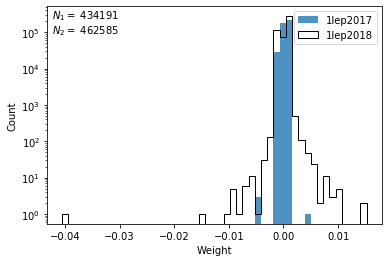

In [12]:
bins = np.linspace(min(min(weightOne),min(weightTwo)),max(max(weightOne),max(weightTwo)),50)
#bins = np.linspace(-5,5,50)
plt.close()
plt.figure()
plt.hist(
    weightOne, bins=bins, label=sampleDirOne.value.split("_")[1],
    histtype="stepfilled",alpha=0.8
)
plt.hist(
    weightTwo, bins=bins, label=sampleDirTwo.value.split("_")[1],
    histtype="step",color="black"
)
plt.annotate(
    u"$N_1=$ {}".format( len( weightOne ) ),
    xycoords = "axes pixels",
    xy = (5,205)
)
plt.annotate(
    u"$N_2=$ {}".format( len( weightTwo ) ),
    xycoords = "axes pixels",
    xy = (5,190)
)
plt.ylabel("Count")
plt.xlabel("Weight")
plt.legend(loc="best")
plt.yscale("log")
plt.show()

### Apply the selection mask to the desired input variable

In [13]:
print("Choose the variable to compare:")
fileList = widgets.Dropdown( options = sorted(commonBranches) )
fileList

Choose the variable to compare:


Dropdown(options=('AK4HT', 'AK4HTpMETpLepPt', 'AK4JetBTag_MultiLepCalc_PtOrdered', 'AK4JetDeepCSVb_MultiLepCal…

In [39]:
# define some plotting parameters
minBin = 0
maxBin = 1.0
nBins = 51
binWidth = float( maxBin - minBin ) / float(nBins)
if len(sampleOne.value) < 2:
    sampleType = "Signal"
else:
    sampleType = "Background"

histBins = np.linspace(minBin, maxBin, nBins)

In [40]:
# populate the branches
branchOne = {}
branchTwo = {}

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    branchOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))
for file in sampleTwo.value:
    branchTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))

branchOneComb = np.concatenate([branchOne[file] for file in sampleOne.value])
branchTwoComb = np.concatenate([branchTwo[file] for file in sampleTwo.value])

branchOneSort = branchOneComb[np.lexsort((branchOneComb[:,1],branchOneComb[:,0]))][:,2]
branchTwoSort = branchTwoComb[np.lexsort((branchTwoComb[:,1],branchTwoComb[:,0]))][:,2]

branchCutOne = branchOneSort[cutMaskOne.astype(bool)]
branchCutTwo = branchTwoSort[cutMaskTwo.astype(bool)]

weightCutOne = weightOne[cutMaskOne.astype(bool)]
weightCutTwo = weightTwo[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 3.72 seconds...


### Populate histograms with weighting

Pre-selection histogram

In [ ]:
histWgtOne = np.zeros(nBins)
histWgtTwo = np.zeros(nBins)
startTime = time.time()

for i, event in enumerate(branchOneSort):
    for binIndx in range(nBins):
        if event >= binIndx*binWidth and event < (1+binIndx)*binWidth:
            histWgtOne[binIndx] += weightOne[i]
            continue
for i, event in enumerate(branchTwoSort):
    for binIndx in range(nBins):
        if event >= binIndx*binWidth and event < (1+binIndx)*binWidth:
            histWgtTwo[binIndx] += weightTwo[i]
            continue
            
print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

Post-selection histogram

In [ ]:
histWgtCutOne = np.zeros(nBins)
histWgtCutTwo = np.zeros(nBins)
startTime = time.time()

for i, event in enumerate(branchCutOne):
    for binIndx in range(nBins):
        if event >= binIndx*binWidth and event < (1+binIndx)*binWidth:
            histWgtCutOne[binIndx] += weightCutOne[i]
            continue
for i, event in enumerate(branchCutTwo):
    for binIndx in range(nBins):
        if event >= binIndx*binWidth and event < (1+binIndx)*binWidth:
            histWgtCutTwo[binIndx] += weightCutTwo[i]
            continue
            
print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

## Plot the two distributions
The (two sample) Kolmogorov-Smirnov test is used to evaluate if the two input distributions are sampled from the same parent population. Two metrics are provided: the Kolmogrov-Smirnov statistic ($D$) and the $p$-value.  $D$ represents a determinant which determines whether the null hypothesis of being similarly sampled is rejected,
$$D_{n,m}>c(\alpha)\sqrt{\frac{n+m}{n\times m}}$$
where $c(\alpha)$ is given by,
$$c(\alpha)=\sqrt{-\ln(\frac{\alpha}{2})\times \frac{1}{2}}$$
and $n$ and $m$ are the sizes of the respective distributions.

The $p$-value is evaluated by whether it is above or below the set $\alpha$.  That is, if $p>\alpha$, then the null hypothesis is not rejected.  Thus, either $D$ or $p$ can be used in evaluating the similarity of the distributions.

### Plot the pre-selection distributions

In [ ]:
# set uniform binning
bins = np.linspace(minBin,maxBin,nBins).reshape(nBins)

# plot the histograms
plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11, 6) )
plt.title( sampleType + " " + str(fileList.value) )
histOne, binsOne, _ = plt.hist(
    branchOneSort,
    label = sampleDirOne.value.split("_")[1],
    histtype = "stepfilled",
    linewidth = 2,
    alpha = 0.9,
    bins = bins,
    density = False
)
histTwo, binsTwo, _ = plt.hist(
    branchTwoSort,
    label = sampleDirTwo.value.split("_")[1],
    histtype = "step",
    linewidth = 2,
    color = "k",
    alpha = 1.0,
    bins = bins,
    density = False
)

D, pVal = stats.ks_2samp(histOne, histTwo)

plt.annotate(
    u"$N_1=$ {}".format( len( branchOneSort ) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {}".format( len( branchTwoSort ) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)

plt.xlabel( str(fileList.value) )
plt.ylabel( "Count" )
plt.ylim(0,1.2*max(max(histOne),max(histTwo)))
plt.xlim(minBin,maxBin)
#plt.yscale( "log" )
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.show()

In [ ]:
normOne = auc(histBins,histWgtOne)
normTwo = auc(histBins,histWgtOne)

plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11,6) )
plt.title( sampleType + " " + str(fileList.value) + " with weights")
plt.plot(
    histBins,histWgtOne/normOne,
    linestyle="none",marker="o",
    alpha=0.8,
    label=sampleDirTwo.value.split("_")[1]
)
plt.plot(
    histBins,histWgtTwo/normTwo,
    linestyle="none",marker="o",fillstyle="none",markeredgecolor="black",
    label=sampleDirOne.value.split("_")[1]
)

D, pVal = stats.ks_2samp(histWgtOne, histWgtTwo)

plt.annotate(
    u"$N_1=$ {:.2f}".format( sum(histWgtOne) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {:.2f}".format( sum(histWgtTwo) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)
plt.xlabel(fileList.value)
plt.ylabel("Normalized Count")
plt.xlim(minBin,maxBin)
plt.ylim(0,1.2*max(max(histWgtOne/normOne),max(histWgtTwo/normTwo)))
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.show()

### Plot the distributions for the cut histograms

In [ ]:
# set uniform binning
bins = np.linspace(minBin,maxBin,nBins).reshape(nBins)

# plot the histograms
plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11, 6) )
plt.title(r"{} {} after selection $(n_j\geq${},$n_b\geq${})".format(sampleType,fileList.value,str(nJets),str(bJets)))
histOne, binsOne, _ = plt.hist(
    branchCutOne,
    label = sampleDirOne.value.split("_")[1],
    histtype = "stepfilled",
    linewidth = 2,
    alpha = 0.9,
    bins = bins,
    density = False
)
histTwo, binsTwo, _ = plt.hist(
    branchCutTwo,
    label = sampleDirTwo.value.split("_")[1],
    histtype = "step",
    linewidth = 2,
    color = "k",
    alpha = 1.0,
    bins = bins,
    density = False
)

D, pVal = stats.ks_2samp(histOne, histTwo)

plt.annotate(
    u"$N_1=$ {}".format( len( branchCutOne ) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {}".format( len( branchCutTwo ) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)

plt.xlabel( str(fileList.value) )
plt.ylabel( "Count" )
plt.xlim(minBin,maxBin)
plt.ylim(0,1.2*max(max(histOne),max(histTwo)))
#plt.yscale( "log" )
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.show()

In [ ]:
normCutOne = auc(histBins,histWgtCutOne)
normCutTwo = auc(histBins,histWgtCutTwo)

plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11,6) )
plt.title(r"{} {} with weights after selection $(n_j\geq${},$n_b\geq${})".format(sampleType,fileList.value,str(nJets),str(bJets)))
plt.plot(
    histBins,histWgtCutOne/normCutOne,
    linestyle="none",marker="o",
    alpha=0.8,
    
    label=sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1]
)
plt.plot(
    histBins,histWgtCutTwo/normCutTwo,
    linestyle="none",marker="o",fillstyle="none",markeredgecolor="black",
    #fill = False,
    label=sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1]
)

D, pVal = stats.ks_2samp(histWgtCutOne, histWgtCutTwo)

plt.annotate(
    u"$N_1=$ {:.2f}".format( sum(histWgtCutOne) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {:.2f}".format( sum(histWgtCutTwo) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)
plt.xlabel(str(fileList.value))
plt.ylabel("Normalized Count")

plt.xlim(minBin,maxBin)
plt.ylim(0,1.2*max(max(histWgtCutOne/normCutOne),max(histWgtCutTwo/normCutTwo)))
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.savefig("{}{}j/{} {}({}j).png".format(defaultSaveDir,str(nJets),sampleType,str(fileList.value),str(nJets)))
plt.show()